In [1]:
import os

import plots.colored_noise_plots

os.chdir('c:\\Users\\sigmu\\PycharmProjects\\thesis')
print(os.listdir())

['.git', '.gitignore', '.idea', 'data', 'outputs', 'phase_noise_check_corr.ipynb', 'phase_noise_check_mat_eng.ipynb', 'phase_noise_graph.ipynb', 'plots', 'simulation', 'tmpo.jpeg']


In [2]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from progressbar import progressbar
from simulation.lane import create_accurate_rhumb_lane
from simulation.config import SIGNAL_PARAMS, LANE_PARAMS
from simulation.phase_noise.monte_carlo import get_monte_carlo_err_as_function_of_fs, get_colored_noise_matlab, get_colored_noise_python, get_psd_params, COLORS_BETA
from simulation.phase_noise.analytic import get_analytic_err_as_function_of_fs, get_analytic_h_factor, inv_vt_v_vt
from plots.colored_noise_plots import compare_analytic_and_monte_carlo_for_colored_noise
from scipy.signal import welch
import time

In [3]:
sim_cores = ['matlab', 'python']
colors = ['purple', 'blue', 'white', 'pink', 'brown']
ensemble_size = SIGNAL_PARAMS['ensemble_size']
lane = create_accurate_rhumb_lane()
vel = lane['vel']
expls = ['angle_mae', 'naive_vec_rmse', 'samples_number', 'vec_rmse']
print(SIGNAL_PARAMS['fs'])

25000


In [4]:
def get_psd_to_plot(signal, fs, nperseg=1024):
    f, pxx = welch(signal, fs=fs, axis=0, nperseg=nperseg)
    pxx_mean = pxx.mean(axis=1)
    pxx_std = pxx.std(axis=1)
    return f, pxx_mean, pxx_std

In [5]:
def get_hist_graphs(color, noise_python, noise_matlab):
    hist_fig, hist_ax = plt.subplots(1, 2, figsize=(4, 6), dpi=180)
    hist_ax[0].hist(noise_matlab.reshape(-1,1), bins=100)
    hist_ax[0].set_title(f'matlab hist for {color} noise')
    hist_ax[1].hist(noise_python.reshape(-1,1), bins=100)
    hist_ax[1].set_title(f'python hist for {color} noise')
    hist_fig.patch.set_facecolor('gray')
    hist_ax[0].set_facecolor('gray')
    hist_ax[1].set_facecolor('gray')
    return hist_fig, hist_ax

def get_noise_lines(noise_samples, fs):
    psd_params = get_psd_params(noise_samples, fs)
    f_vec, pxx_mean, pxx_std = get_psd_to_plot(noise_samples, fs)
    psd_approx = 10 ** (psd_params[1] + np.log10(f_vec[5:-5]) * psd_params[0])
    return f_vec, pxx_mean, pxx_std, psd_params, psd_approx

def get_theoretical_psd(color, f_vec, adev, fs):
    h_factor = get_analytic_h_factor(COLORS_BETA[color], adev, fs/2)
    psd_analytic = 10 ** (np.log10(h_factor) + np.log10(f_vec[5:-5]) * COLORS_BETA[color])
    return psd_analytic

def plot_noise_for_one_origin(psd_ax, origin, lines_colors, f_vec, pxx_mean, pxx_std, psd_params, psd_approx):
    psd_ax.loglog(f_vec, pxx_mean, lines_colors[0], label=f'{origin} PSD')
    psd_ax.fill_between(f_vec, pxx_mean - pxx_std, pxx_mean + pxx_std, facecolor=lines_colors[1], alpha=0.2, label=f'_{origin} PSD')
    psd_ax.loglog(f_vec[5:-5], psd_approx, lines_colors[2], label=f'{origin} {np.round(psd_params[0], 3)}')

def get_noise_graphs(color, python_vecs, matlab_vecs, psd_analytic):
    psd_fig, psd_ax = plt.subplots(1, 1, figsize=(8, 6), dpi=180)
    python_lines_colors = ('r', '#FF9848', 'g:*')
    matlab_lines_colors = ('b', '#089FFF', 'm:*')
    if matlab_vecs is not None:
        plot_noise_for_one_origin(psd_ax, 'matlab', matlab_lines_colors, *matlab_vecs)
        f_vec = matlab_vecs[0].copy()
    if python_vecs is not None:
        plot_noise_for_one_origin(psd_ax, 'python', python_lines_colors, *python_vecs)
        f_vec = python_vecs[0].copy()
    psd_ax.loglog(f_vec[5:-5], psd_analytic, 'k', label=f'analytic')

    psd_ax.set_xlabel('f [Hz]')
    psd_ax.set_ylabel('PSD')
    psd_ax.set_title(f'PSD comparison for {color}')
    psd_ax.legend(facecolor='gray')
    psd_fig.patch.set_facecolor('gray')
    psd_ax.set_facecolor('gray')
    return psd_fig, psd_ax

def get_noise_preview_for_matlab_alone(color='purple', ensemble_size=ensemble_size, fs=SIGNAL_PARAMS['fs'], adev=SIGNAL_PARAMS['adev']):
    mega_func_disc = ['matlab_vecs', 'psd_analytic', 'psd_fig', 'psd_ax']
    mini_disc = ['f_vec', 'pxx_mean', 'pxx_std', 'psd_params', 'psd_approx']
    noise_matlab = get_colored_noise_matlab(color, fs, adev, ensemble_size)
    matlab_vecs = get_noise_lines(noise_matlab, fs)  # matlab_f_vec, matlab_pxx_mean, matlab_pxx_std, matlab_psd_params, matlab_psd_approx
    del noise_matlab
    psd_analytic = get_theoretical_psd(color, matlab_vecs[0], adev, fs)
    psd_fig, psd_ax = get_noise_graphs(color, None, matlab_vecs, psd_analytic)
    outputs_tuple = (matlab_vecs, psd_analytic, psd_fig, psd_ax)
    outputs_dict = {}
    for disc, val in zip(mega_func_disc, outputs_tuple):
        if disc == 'matlab_vecs':
            outputs_dict[disc] = {sdisc: sval for sdisc, sval in zip(mini_disc, val)}
        else:
            outputs_dict[disc] = val
    return outputs_dict


def get_noise_preview(color='purple', ensemble_size=ensemble_size, fs=SIGNAL_PARAMS['fs'], adev=SIGNAL_PARAMS['adev']):
    mega_func_disc = ['hist_fig', 'hist_ax', 'python_vecs', 'matlab_vecs', 'psd_analytic', 'psd_fig', 'psd_ax']
    mini_disc = ['f_vec', 'pxx_mean', 'pxx_std', 'psd_params', 'psd_approx']
    noise_python = get_colored_noise_python(color, fs, adev, ensemble_size)
    noise_matlab = get_colored_noise_matlab(color, fs, adev, ensemble_size)
    hist_fig, hist_ax = get_hist_graphs(color, noise_matlab, noise_python)
    python_vecs = get_noise_lines(noise_python, fs)  # python_f_vec, python_pxx_mean, python_pxx_std, python_psd_params, python_psd_approx
    del noise_python
    matlab_vecs = get_noise_lines(noise_matlab, fs)  # matlab_f_vec, matlab_pxx_mean, matlab_pxx_std, matlab_psd_params, matlab_psd_approx
    del noise_matlab
    psd_analytic = get_theoretical_psd(color, python_vecs[0], adev, fs)
    psd_fig, psd_ax = get_noise_graphs(color, python_vecs, matlab_vecs, psd_analytic)
    outputs_tuple = (hist_fig, hist_ax, python_vecs, matlab_vecs, psd_analytic, psd_fig, psd_ax)
    outputs_dict = {}
    for disc, val in zip(mega_func_disc, outputs_tuple):
        if disc in ['python_vecs', 'matlab_vecs']:
            outputs_dict[disc] = {sdisc: sval for sdisc, sval in zip(mini_disc, val)}
        else:
            outputs_dict[disc] = val
    return outputs_dict


def get_noise_preview_for_python_alone(color='purple', ensemble_size=ensemble_size, fs=SIGNAL_PARAMS['fs'], adev=SIGNAL_PARAMS['adev']):
    mega_func_disc = ['python_vecs', 'psd_analytic', 'psd_fig', 'psd_ax']
    mini_disc = ['f_vec', 'pxx_mean', 'pxx_std', 'psd_params', 'psd_approx']
    noise_python = get_colored_noise_python(color, fs, adev, ensemble_size)
    python_vecs = get_noise_lines(noise_python, fs)  # python_f_vec, python_pxx_mean, python_pxx_std, python_psd_params, python_psd_approx
    del noise_python
    psd_analytic = get_theoretical_psd(color, python_vecs[0], adev, fs)
    psd_fig, psd_ax = get_noise_graphs(color, python_vecs, None, psd_analytic)
    outputs_tuple = (python_vecs, psd_analytic, psd_fig, psd_ax)
    outputs_dict = {}
    for disc, val in zip(mega_func_disc, outputs_tuple):
        if disc == 'python_vecs':
            outputs_dict[disc] = {sdisc: sval for sdisc, sval in zip(mini_disc, val)}
        else:
            outputs_dict[disc] = val
    return outputs_dict


start purple
finished purple in 88.699s
start blue
finished blue in 85.808s
start white
finished white in 85.724s
start pink
finished pink in 85.627s
start brown


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

finished brown in 85.475s


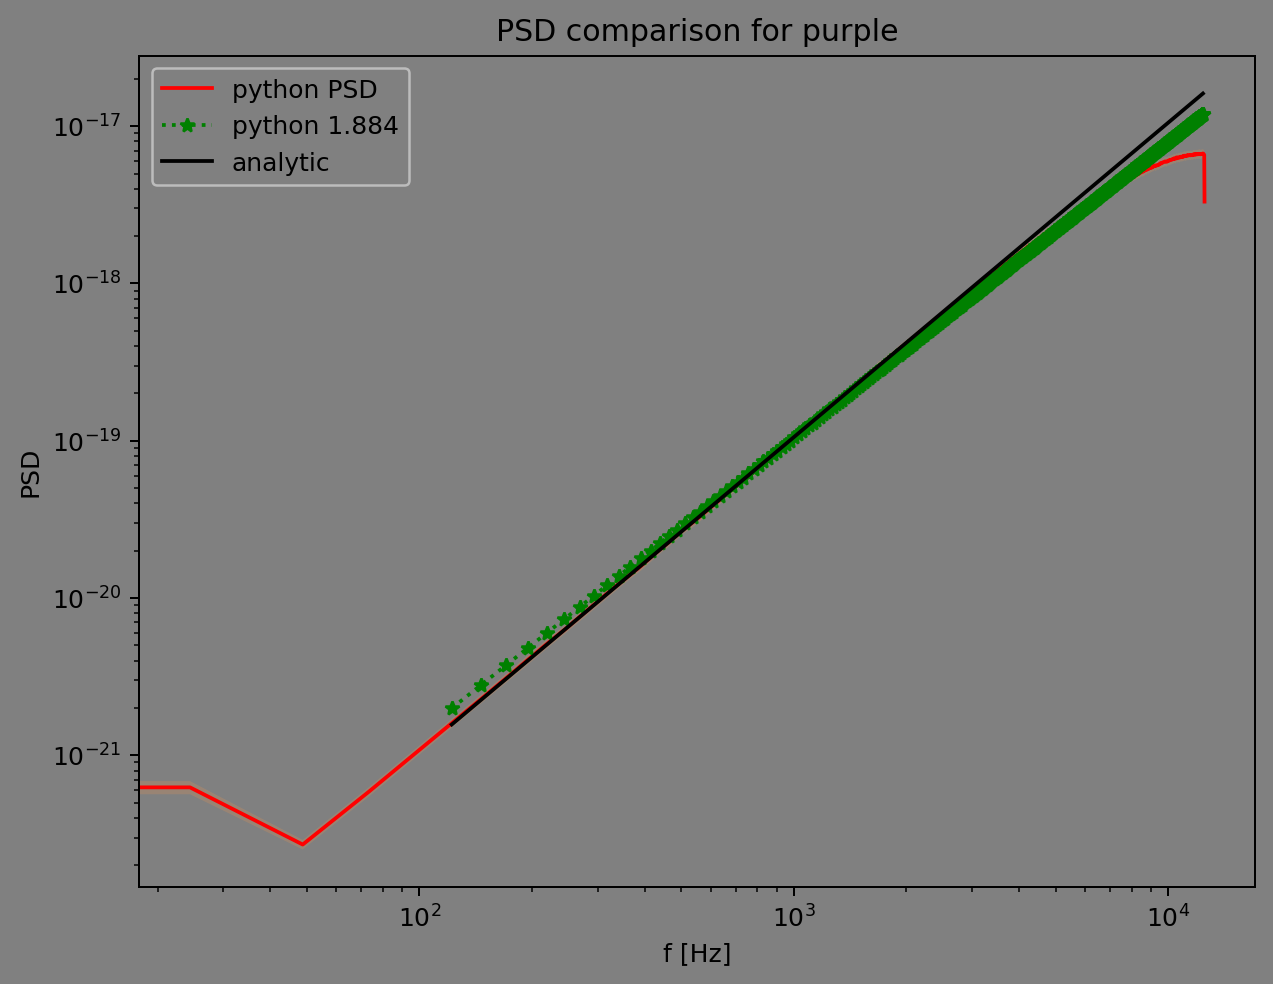

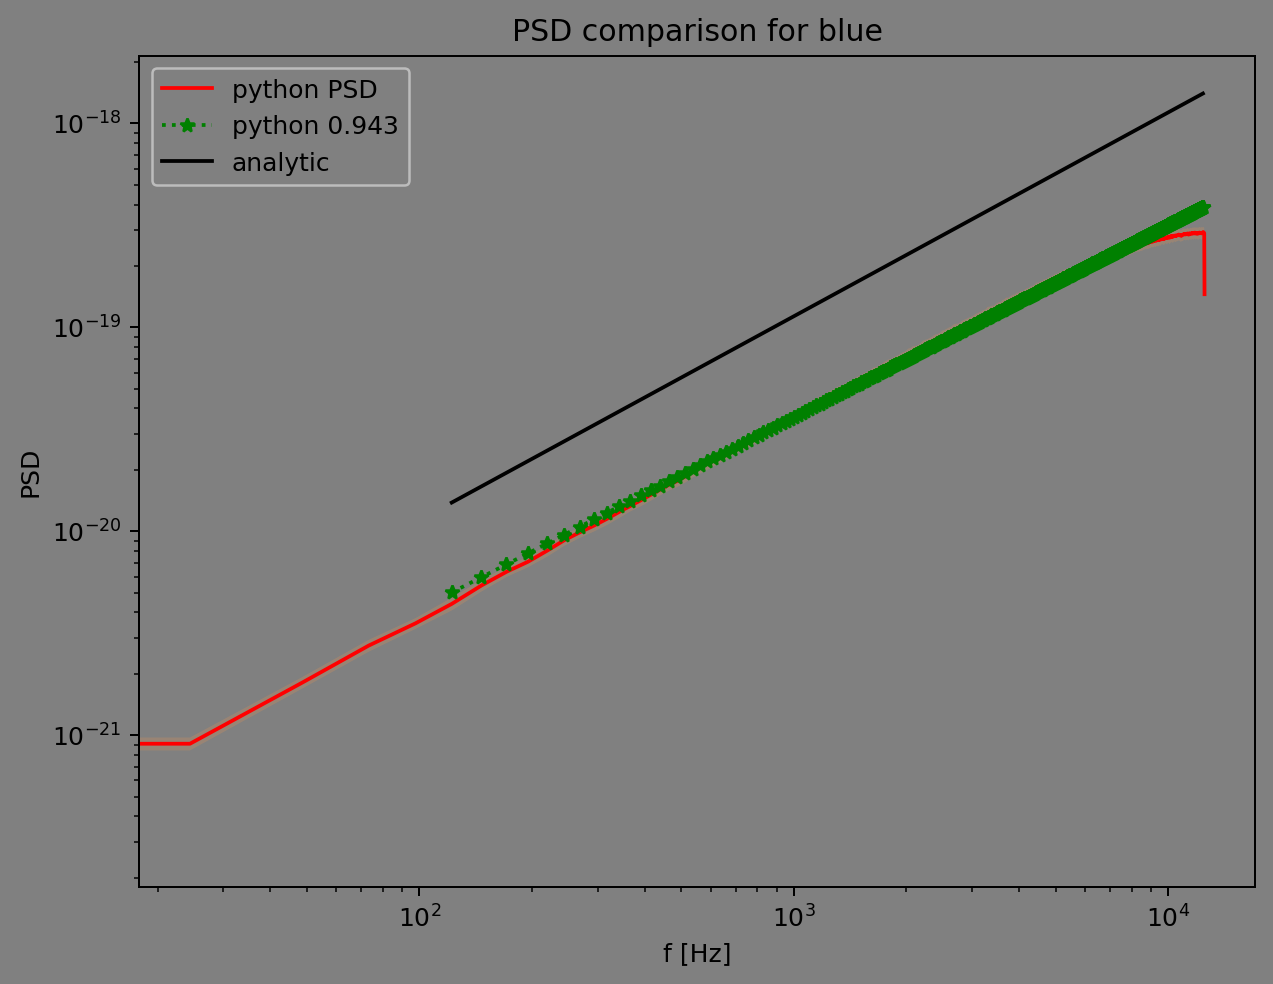

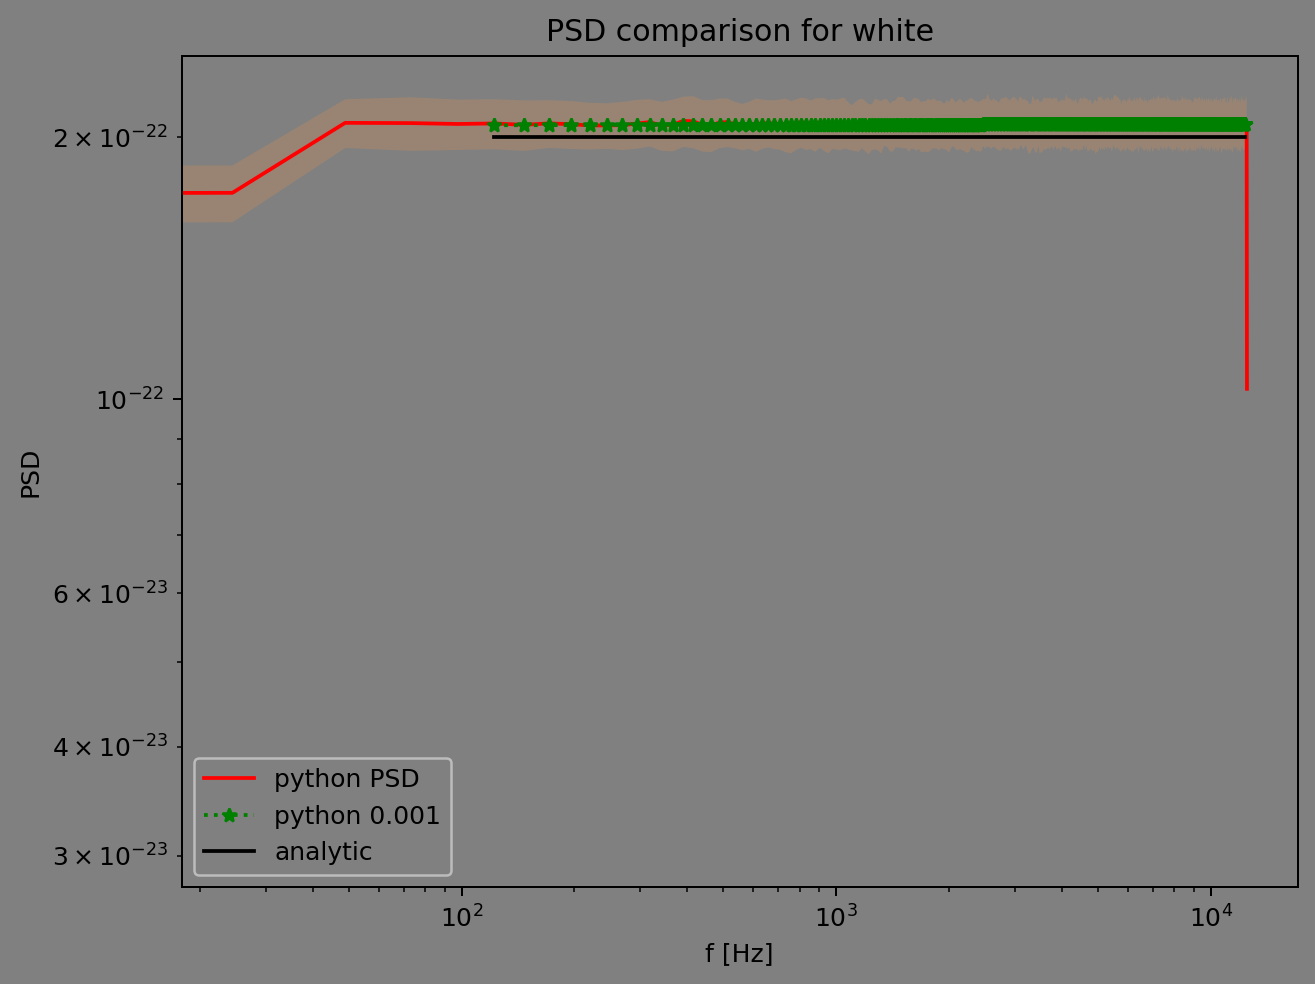

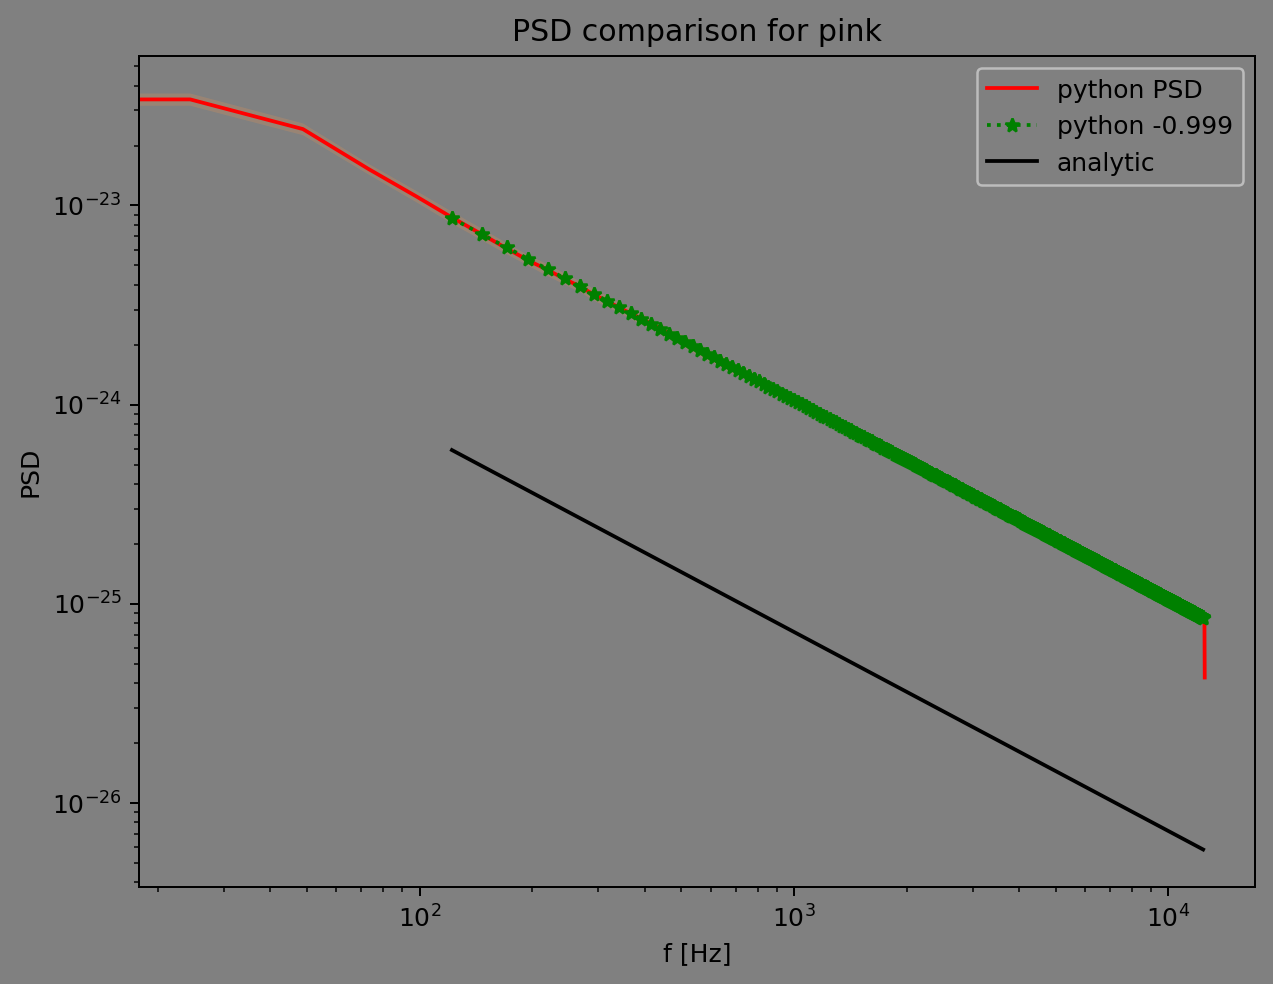

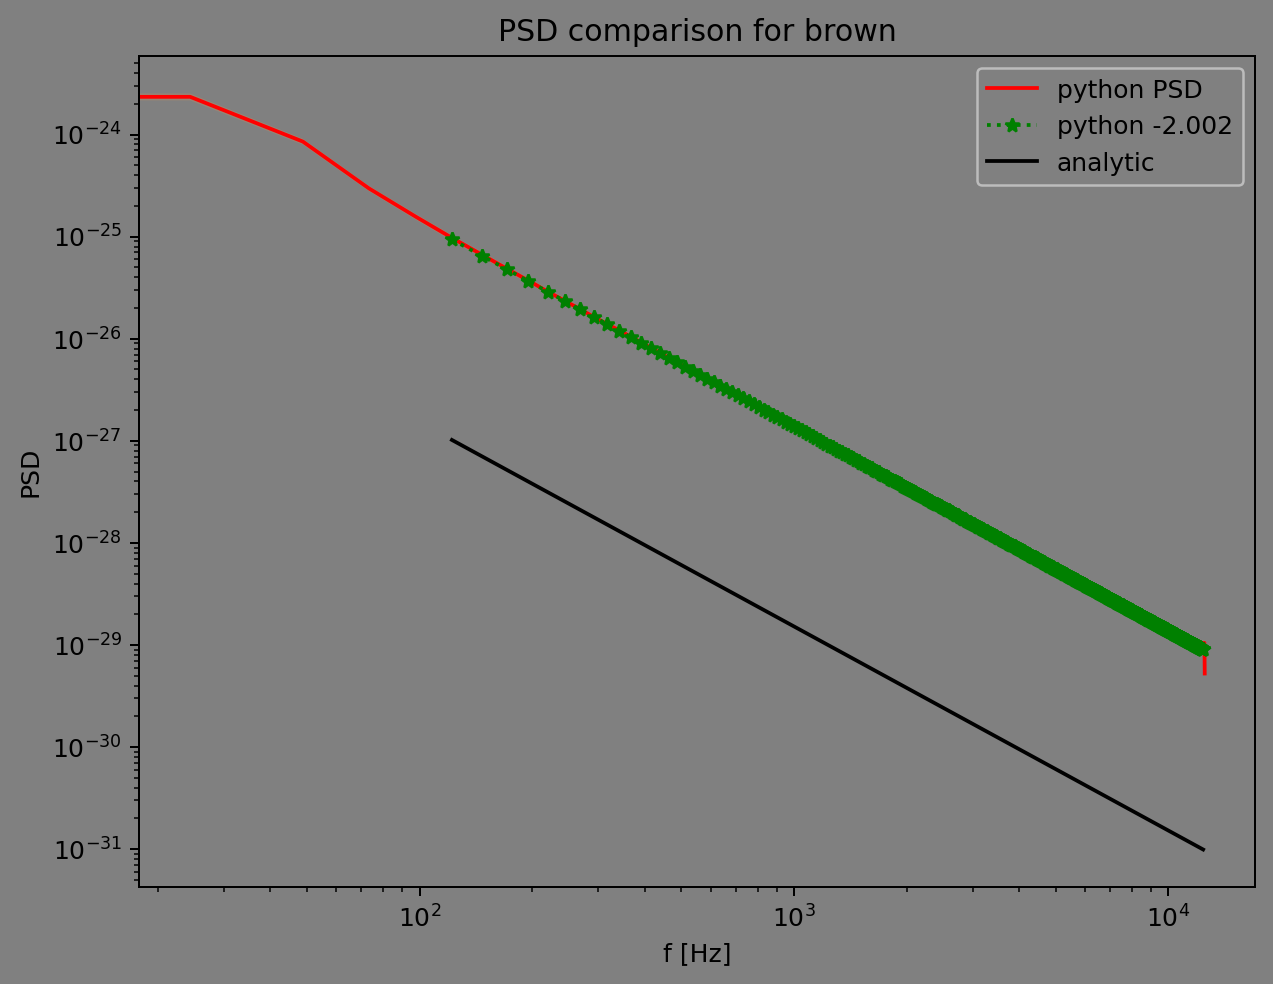

In [6]:
sim_cores = {'matlab': True, 'python': False}
all_outputs_dict = {color: {} for color in COLORS_BETA.keys()}
for color in COLORS_BETA.keys():
    print(f'start {color}')
    t1 = time.time()
    if all(list(sim_cores.values())):
        all_outputs_dict[color] = get_noise_preview(color)
    else:
        if sim_cores['python']:
            all_outputs_dict[color] = get_noise_preview_for_python_alone(color)
        elif sim_cores['matlab']:
            all_outputs_dict[color] = get_noise_preview_for_matlab_alone(color)
    print(f'finished {color} in {np.round(time.time() - t1, 3)}s')

In [7]:
for color in colors:
    c1 = 10 ** all_outputs_dict[color]['matlab_vecs']['psd_params'][1]
    c2 = get_analytic_h_factor(COLORS_BETA[color], SIGNAL_PARAMS['adev'], SIGNAL_PARAMS['fs']/2)
    print(f"{color}: {c1:.4e} / {c2:.4e} = {(c1 / c2):.4f} | {c1:.4e} - {c2:.4e} = {(c1 - c2):.4e}")

purple: 2.3313e-25 / 1.0528e-25 = 2.2144 | 2.3313e-25 - 1.0528e-25 = 1.2785e-25
blue: 5.4000e-23 / 1.1327e-22 = 0.4767 | 5.4000e-23 - 1.1327e-22 = -5.9273e-23
white: 2.0554e-22 / 2.0000e-22 = 1.0277 | 2.0554e-22 - 2.0000e-22 = 5.5363e-24
pink: 1.0486e-21 / 7.2135e-23 = 14.5361 | 1.0486e-21 - 7.2135e-23 = 9.7643e-22
brown: 1.4131e-21 / 1.5198e-23 = 92.9798 | 1.4131e-21 - 1.5198e-23 = 1.3979e-21


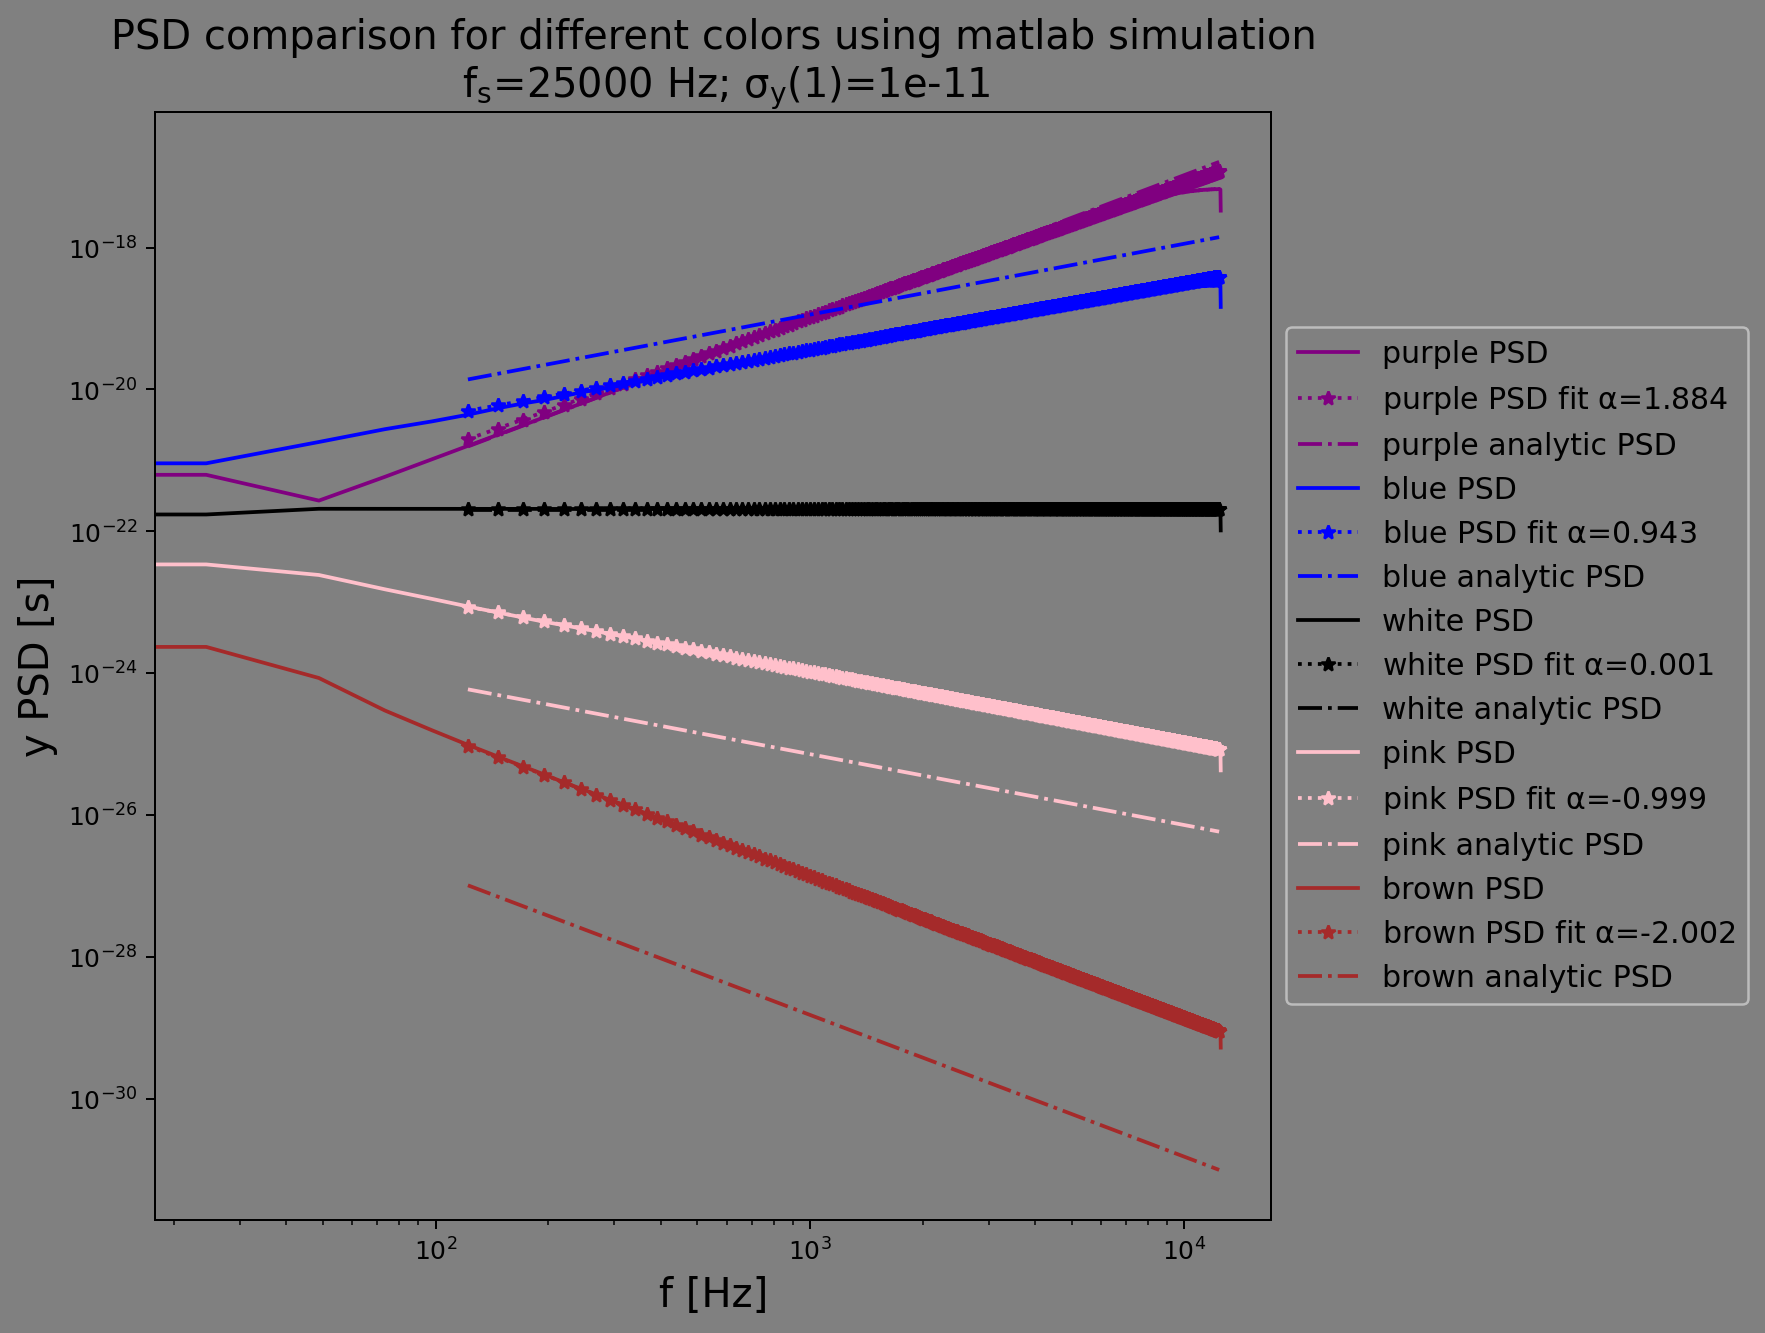

In [8]:
def plot_psd_for_all_colors(all_outputs_dict, sim_core='matlab', save_fig=False):
    psd_fig, psd_ax = plt.subplots(1, 1, figsize=(8, 8), dpi=180)
    for color, color_vals in all_outputs_dict.items():
        linecolor = color
        if linecolor == 'white':
            linecolor = 'black'
        sim_lines = color_vals[f'{sim_core}_vecs']
        psd_ax.loglog(sim_lines['f_vec'], sim_lines['pxx_mean'], '-', color=linecolor, label=f'{color} PSD')
        psd_ax.loglog(sim_lines['f_vec'][5:-5], sim_lines['psd_approx'], ':*', color=linecolor, label=f'{color} PSD fit ' + r"$\alpha$" + f'={np.round(sim_lines["psd_params"][0], 3)}')
        psd_ax.loglog(sim_lines['f_vec'][5:-5], get_theoretical_psd(color, sim_lines['f_vec'], SIGNAL_PARAMS['adev'], SIGNAL_PARAMS['fs']), '-.', color=linecolor, label=f'{color} analytic PSD')

    psd_ax.set_xlabel(r'f [Hz]', fontsize=16)
    psd_ax.set_ylabel(r'y PSD [s]', fontsize=16)
    psd_ax.set_title(f'PSD comparison for different colors using {sim_core} simulation\n'
                     + r'  $f_{s}$=' + f'{SIGNAL_PARAMS["fs"]} Hz; ' + r'$\sigma_{y}(1)$=' + f'{SIGNAL_PARAMS["adev"]}', fontsize=16)
    if save_fig:
        psd_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
        psd_fig.autolayout = True
        psd_fig.savefig(f'c:\\Users\\sigmu\\LyxDir\\thesis\\figures\\figures_from_jupyter\\psd_for_colored_noise_{sim_core}.jpeg',  bbox_inches='tight')
    else:
        psd_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, facecolor='gray')
        psd_fig.autolayout = True
        psd_fig.patch.set_facecolor('gray')
        psd_ax.set_facecolor('gray')
    return psd_fig, psd_ax

psd_fig, psd_ax = plot_psd_for_all_colors(all_outputs_dict, 'matlab', False)

In [9]:
comparison_dict = dict([])

/ |#                                                  | 0 Elapsed Time: 0:00:00

generating purple noise from size (3, 250) using matlab core


- |                   #                               | 1 Elapsed Time: 0:00:22C:\Users\sigmu\PycharmProjects\thesis\simulation\utils.py:56: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  return np.dot(a, a.T)
C:\Users\sigmu\PycharmProjects\thesis\simulation\utils.py:57: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  return np.dot(a, b)
| |     #                                            | 18 Elapsed Time: 0:06:39
- |   #                                               | 1 Elapsed Time: 0:00:00C:\Users\sigmu\PycharmProjects\thesis\simulation\utils.py:57: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  return np.dot(a, b)
| |    

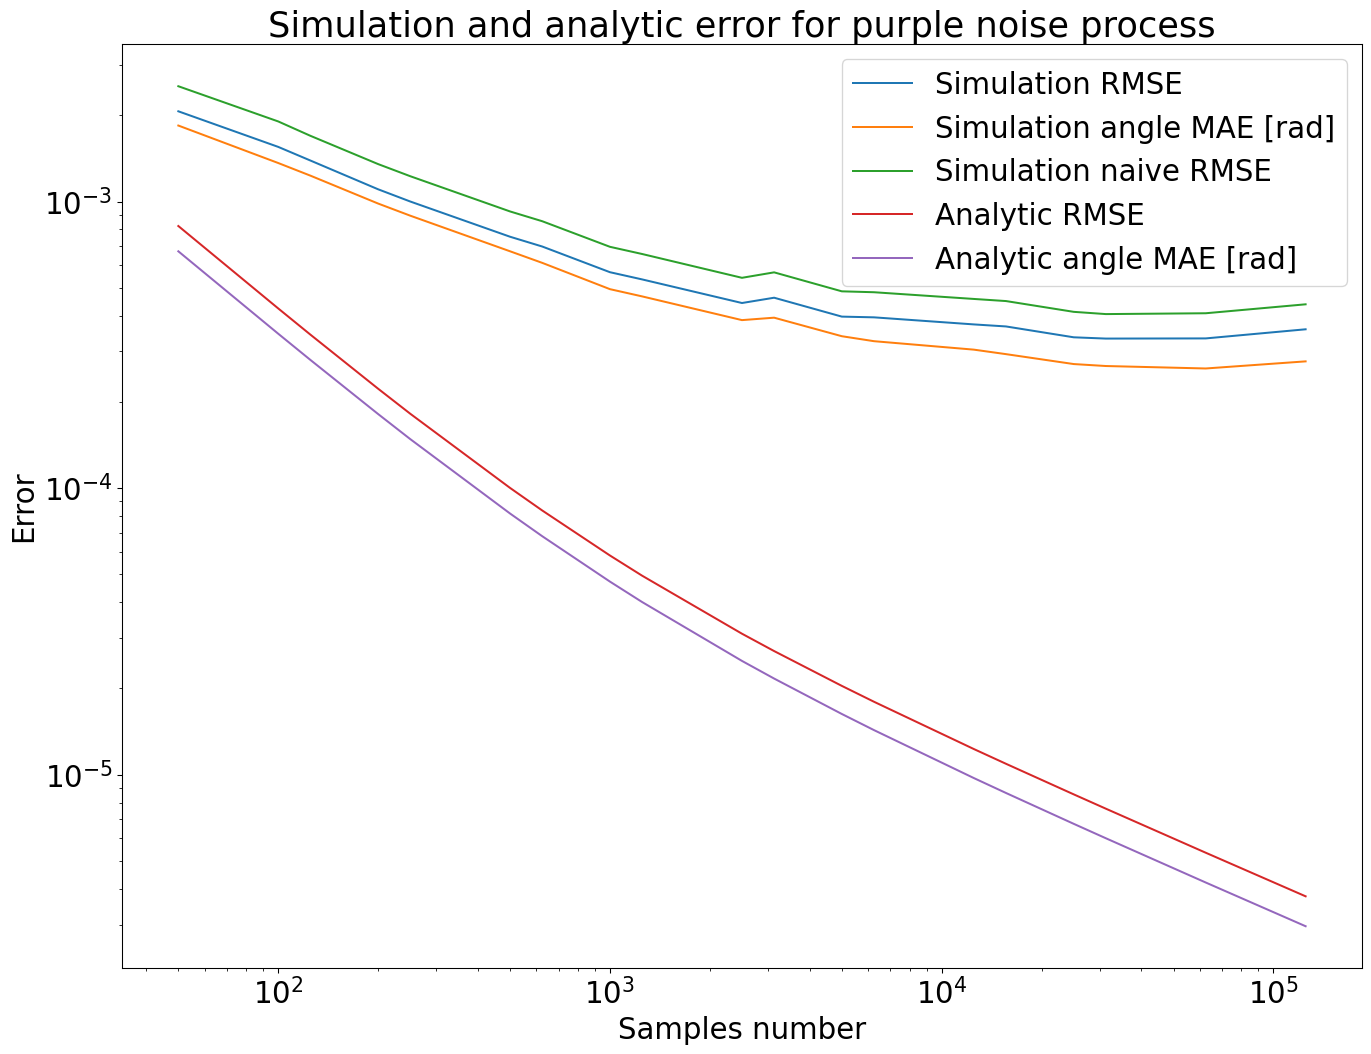

In [10]:
color = 'purple'
comp_disc = ['samples_number', 'sim_vec_rmse', 'sim_angle_mae', 'sim_naive_vec_rmse', 'an_samples_number', 'an_vec_rmse', 'an_angle_mae', 'comp_fig']
comp_opts = \
        compare_analytic_and_monte_carlo_for_colored_noise(color, ensemble_size=SIGNAL_PARAMS['ensemble_size'], save_name=None,
                                                       simulation_core='matlab', recreate_noise_per_fs=False)
comparison_dict[color] = {'simulation': {}, 'analytic': {}}
for val, val_name in zip(comp_opts, comp_disc):
    if val_name.split('_')[0] == 'sim':
        comparison_dict[color]['simulation'][val_name[4:]] = val
    elif val_name.split('_')[0] == 'an':
        comparison_dict[color]['analytic'][val_name[3:]] = val
    else:
        comparison_dict[color][val_name] = val

/ |#                                                  | 0 Elapsed Time: 0:00:00

generating blue noise from size (3, 250) using matlab core


| |                   #                              | 18 Elapsed Time: 0:06:38
/ |#                                                  | 0 Elapsed Time: 0:00:00C:\Users\sigmu\PycharmProjects\thesis\simulation\phase_noise\analytic.py:31: RuntimeWarning: invalid value encountered in divide
  sinc_ci_cos_func = lambda x: np.sin(x)/x - sici(x)[1] - np.cos(x)/x**2
C:\Users\sigmu\PycharmProjects\thesis\simulation\phase_noise\analytic.py:31: RuntimeWarning: divide by zero encountered in divide
  sinc_ci_cos_func = lambda x: np.sin(x)/x - sici(x)[1] - np.cos(x)/x**2
| |                                              #   | 18 Elapsed Time: 0:00:05


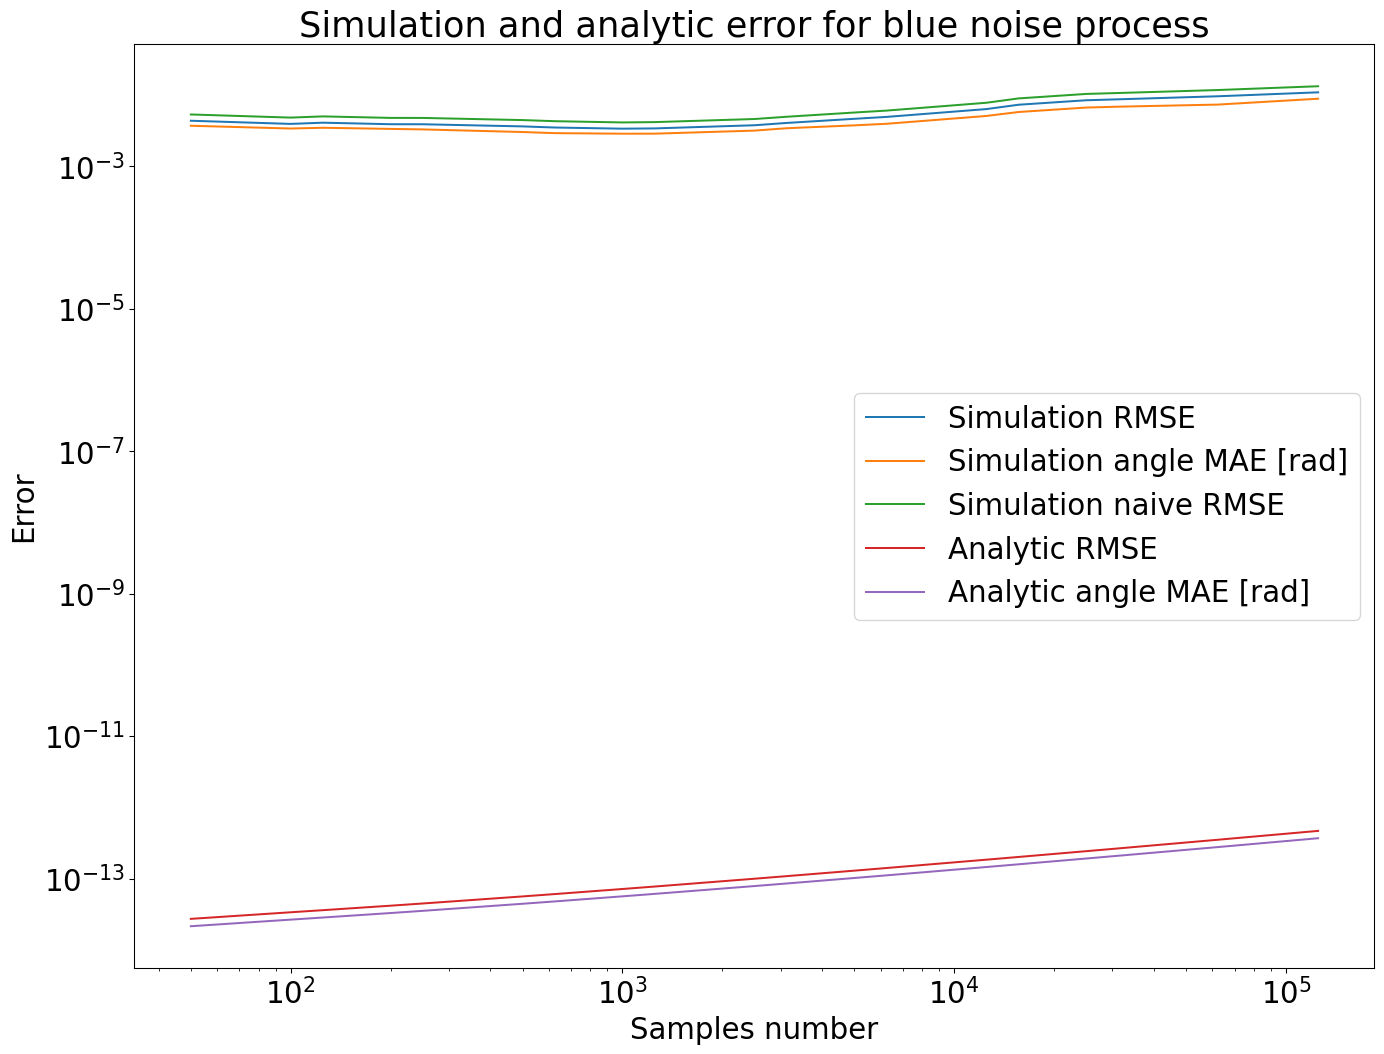

In [11]:
color = 'blue'
comp_opts = \
        compare_analytic_and_monte_carlo_for_colored_noise(color, ensemble_size=SIGNAL_PARAMS['ensemble_size'], save_name=None,
                                                       simulation_core='matlab', recreate_noise_per_fs=False)
comparison_dict[color] = {'simulation': {}, 'analytic': {}}
for val, val_name in zip(comp_opts, comp_disc):
    if val_name.split('_')[0] == 'sim':
        comparison_dict[color]['simulation'][val_name[4:]] = val
    elif val_name.split('_')[0] == 'an':
        comparison_dict[color]['analytic'][val_name[3:]] = val
    else:
        comparison_dict[color][val_name] = val

/ |#                                                  | 0 Elapsed Time: 0:00:00

generating white noise from size (3, 250) using matlab core


| |                           #                      | 18 Elapsed Time: 0:06:37
| |    #                                             | 18 Elapsed Time: 0:00:00


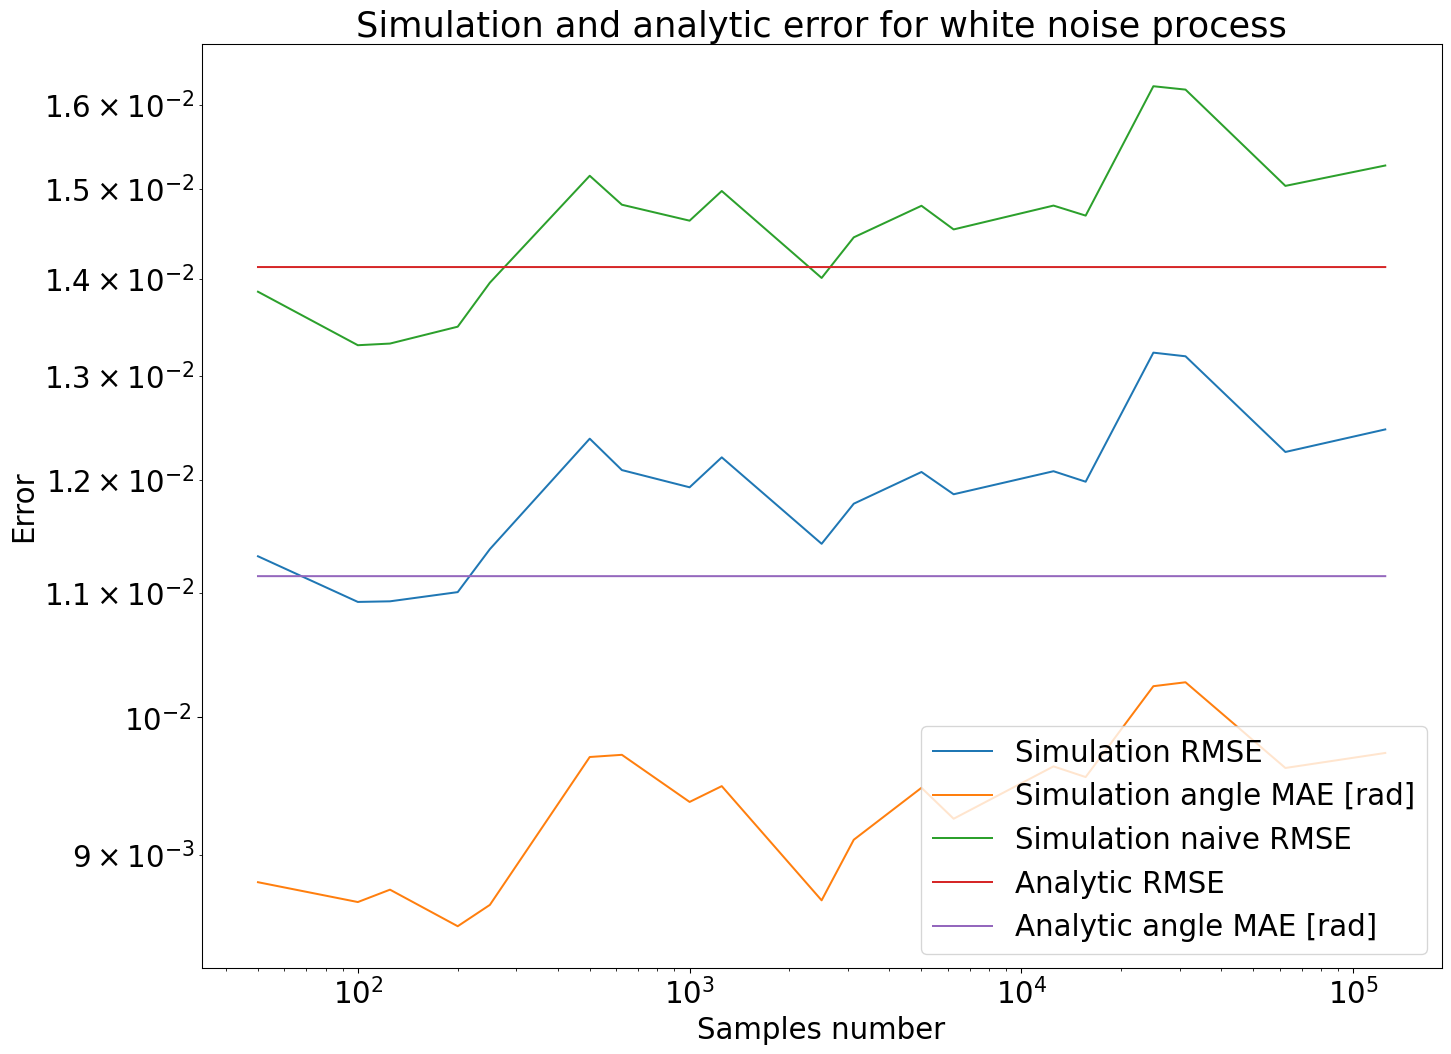

In [12]:
color = 'white'
comp_opts = \
        compare_analytic_and_monte_carlo_for_colored_noise(color, ensemble_size=SIGNAL_PARAMS['ensemble_size'], save_name=None,
                                                       simulation_core='matlab', recreate_noise_per_fs=False)
comparison_dict[color] = {'simulation': {}, 'analytic': {}}
for val, val_name in zip(comp_opts, comp_disc):
    if val_name.split('_')[0] == 'sim':
        comparison_dict[color]['simulation'][val_name[4:]] = val
    elif val_name.split('_')[0] == 'an':
        comparison_dict[color]['analytic'][val_name[3:]] = val
    else:
        comparison_dict[color][val_name] = val

/ |#                                                  | 0 Elapsed Time: 0:00:00

generating pink noise from size (3, 250) using matlab core


| |                              #                   | 18 Elapsed Time: 0:06:36
/ |#                                                  | 0 Elapsed Time: 0:00:00C:\Users\sigmu\PycharmProjects\thesis\simulation\phase_noise\analytic.py:162: RuntimeWarning: invalid value encountered in subtract
  w_pink = sici(2 * fh * np.pi * np.arange(n_samples) / fs)[1] - sici(2 * fl * np.pi * np.arange(n_samples) / fs)[1]
| |                                              #   | 18 Elapsed Time: 0:00:05


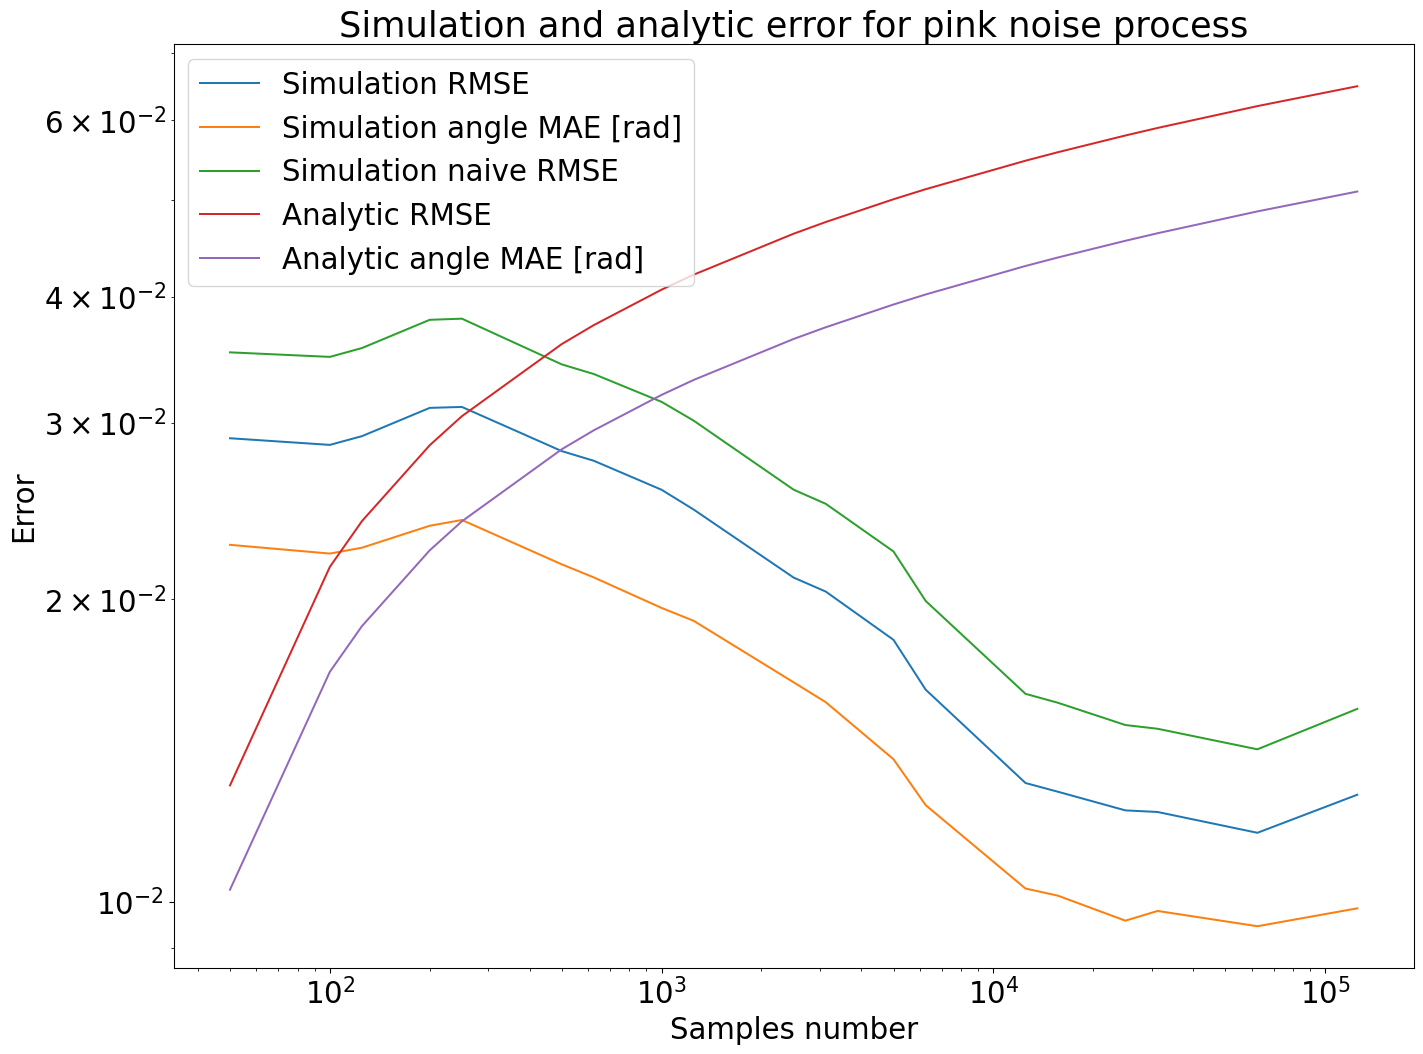

In [13]:
color = 'pink'
comp_opts = \
        compare_analytic_and_monte_carlo_for_colored_noise(color, ensemble_size=SIGNAL_PARAMS['ensemble_size'], save_name=None,
                                                       simulation_core='matlab', recreate_noise_per_fs=False)
comparison_dict[color] = {'simulation': {}, 'analytic': {}}
for val, val_name in zip(comp_opts, comp_disc):
    if val_name.split('_')[0] == 'sim':
        comparison_dict[color]['simulation'][val_name[4:]] = val
    elif val_name.split('_')[0] == 'an':
        comparison_dict[color]['analytic'][val_name[3:]] = val
    else:
        comparison_dict[color][val_name] = val

/ |#                                                  | 0 Elapsed Time: 0:00:00

generating brown noise from size (3, 250) using matlab core


| |                 #                                | 18 Elapsed Time: 0:06:38
| |     #                                            | 18 Elapsed Time: 0:00:00


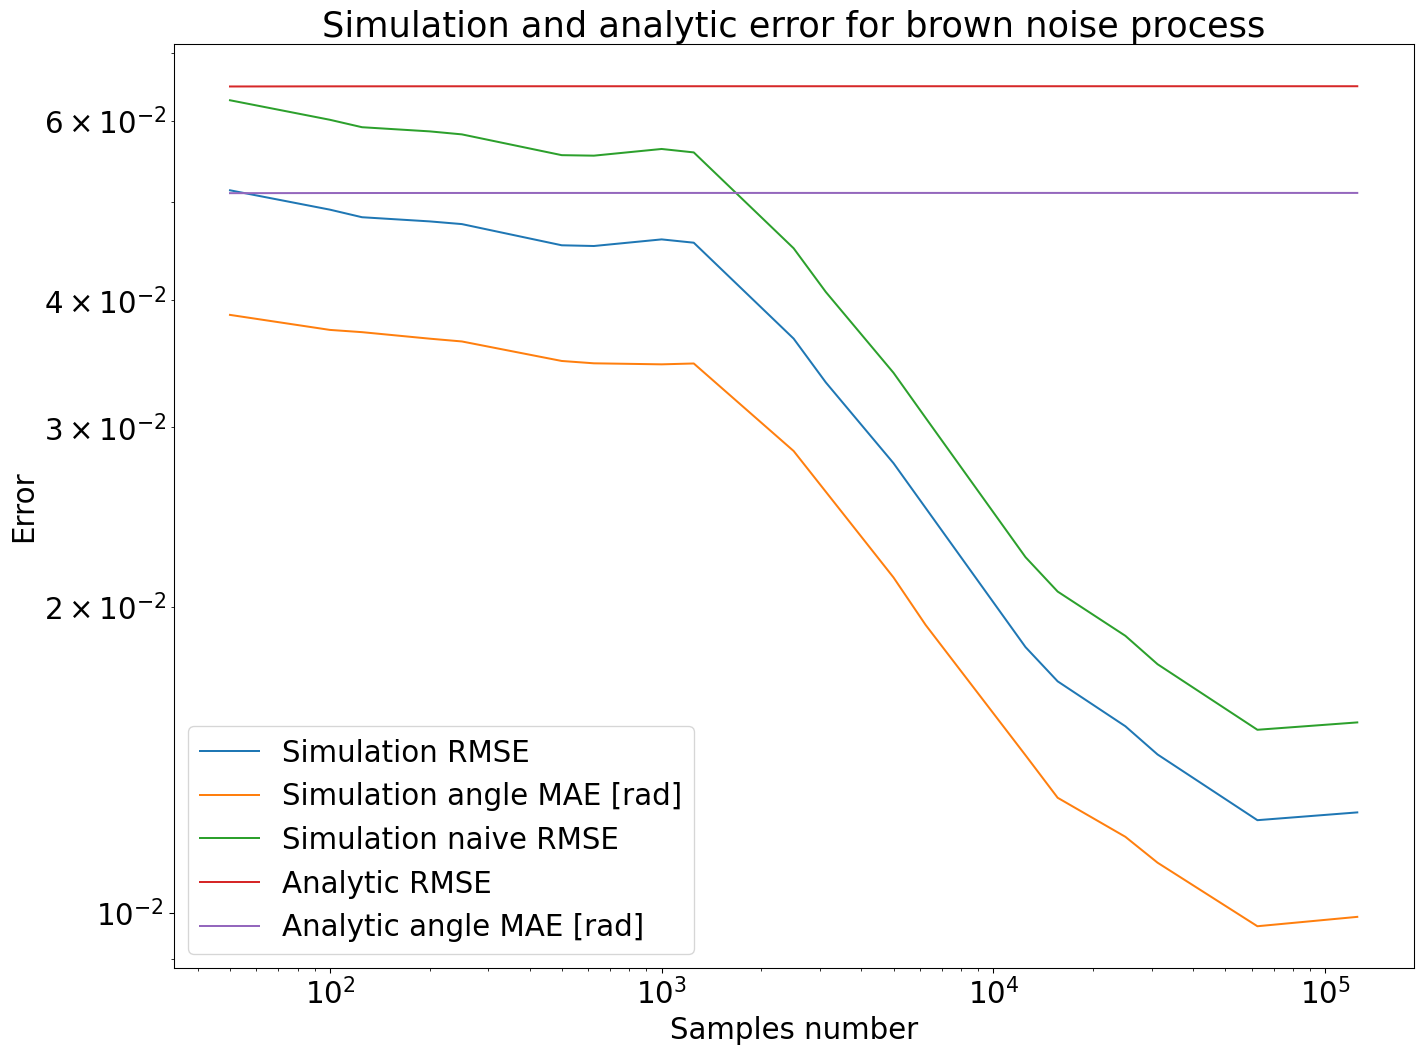

In [14]:
color = 'brown'
comp_opts = \
        compare_analytic_and_monte_carlo_for_colored_noise(color, ensemble_size=SIGNAL_PARAMS['ensemble_size'], save_name=None,
                                                       simulation_core='matlab', recreate_noise_per_fs=False)
comparison_dict[color] = {'simulation': {}, 'analytic': {}}
for val, val_name in zip(comp_opts, comp_disc):
    if val_name.split('_')[0] == 'sim':
        comparison_dict[color]['simulation'][val_name[4:]] = val
    elif val_name.split('_')[0] == 'an':
        comparison_dict[color]['analytic'][val_name[3:]] = val
    else:
        comparison_dict[color][val_name] = val

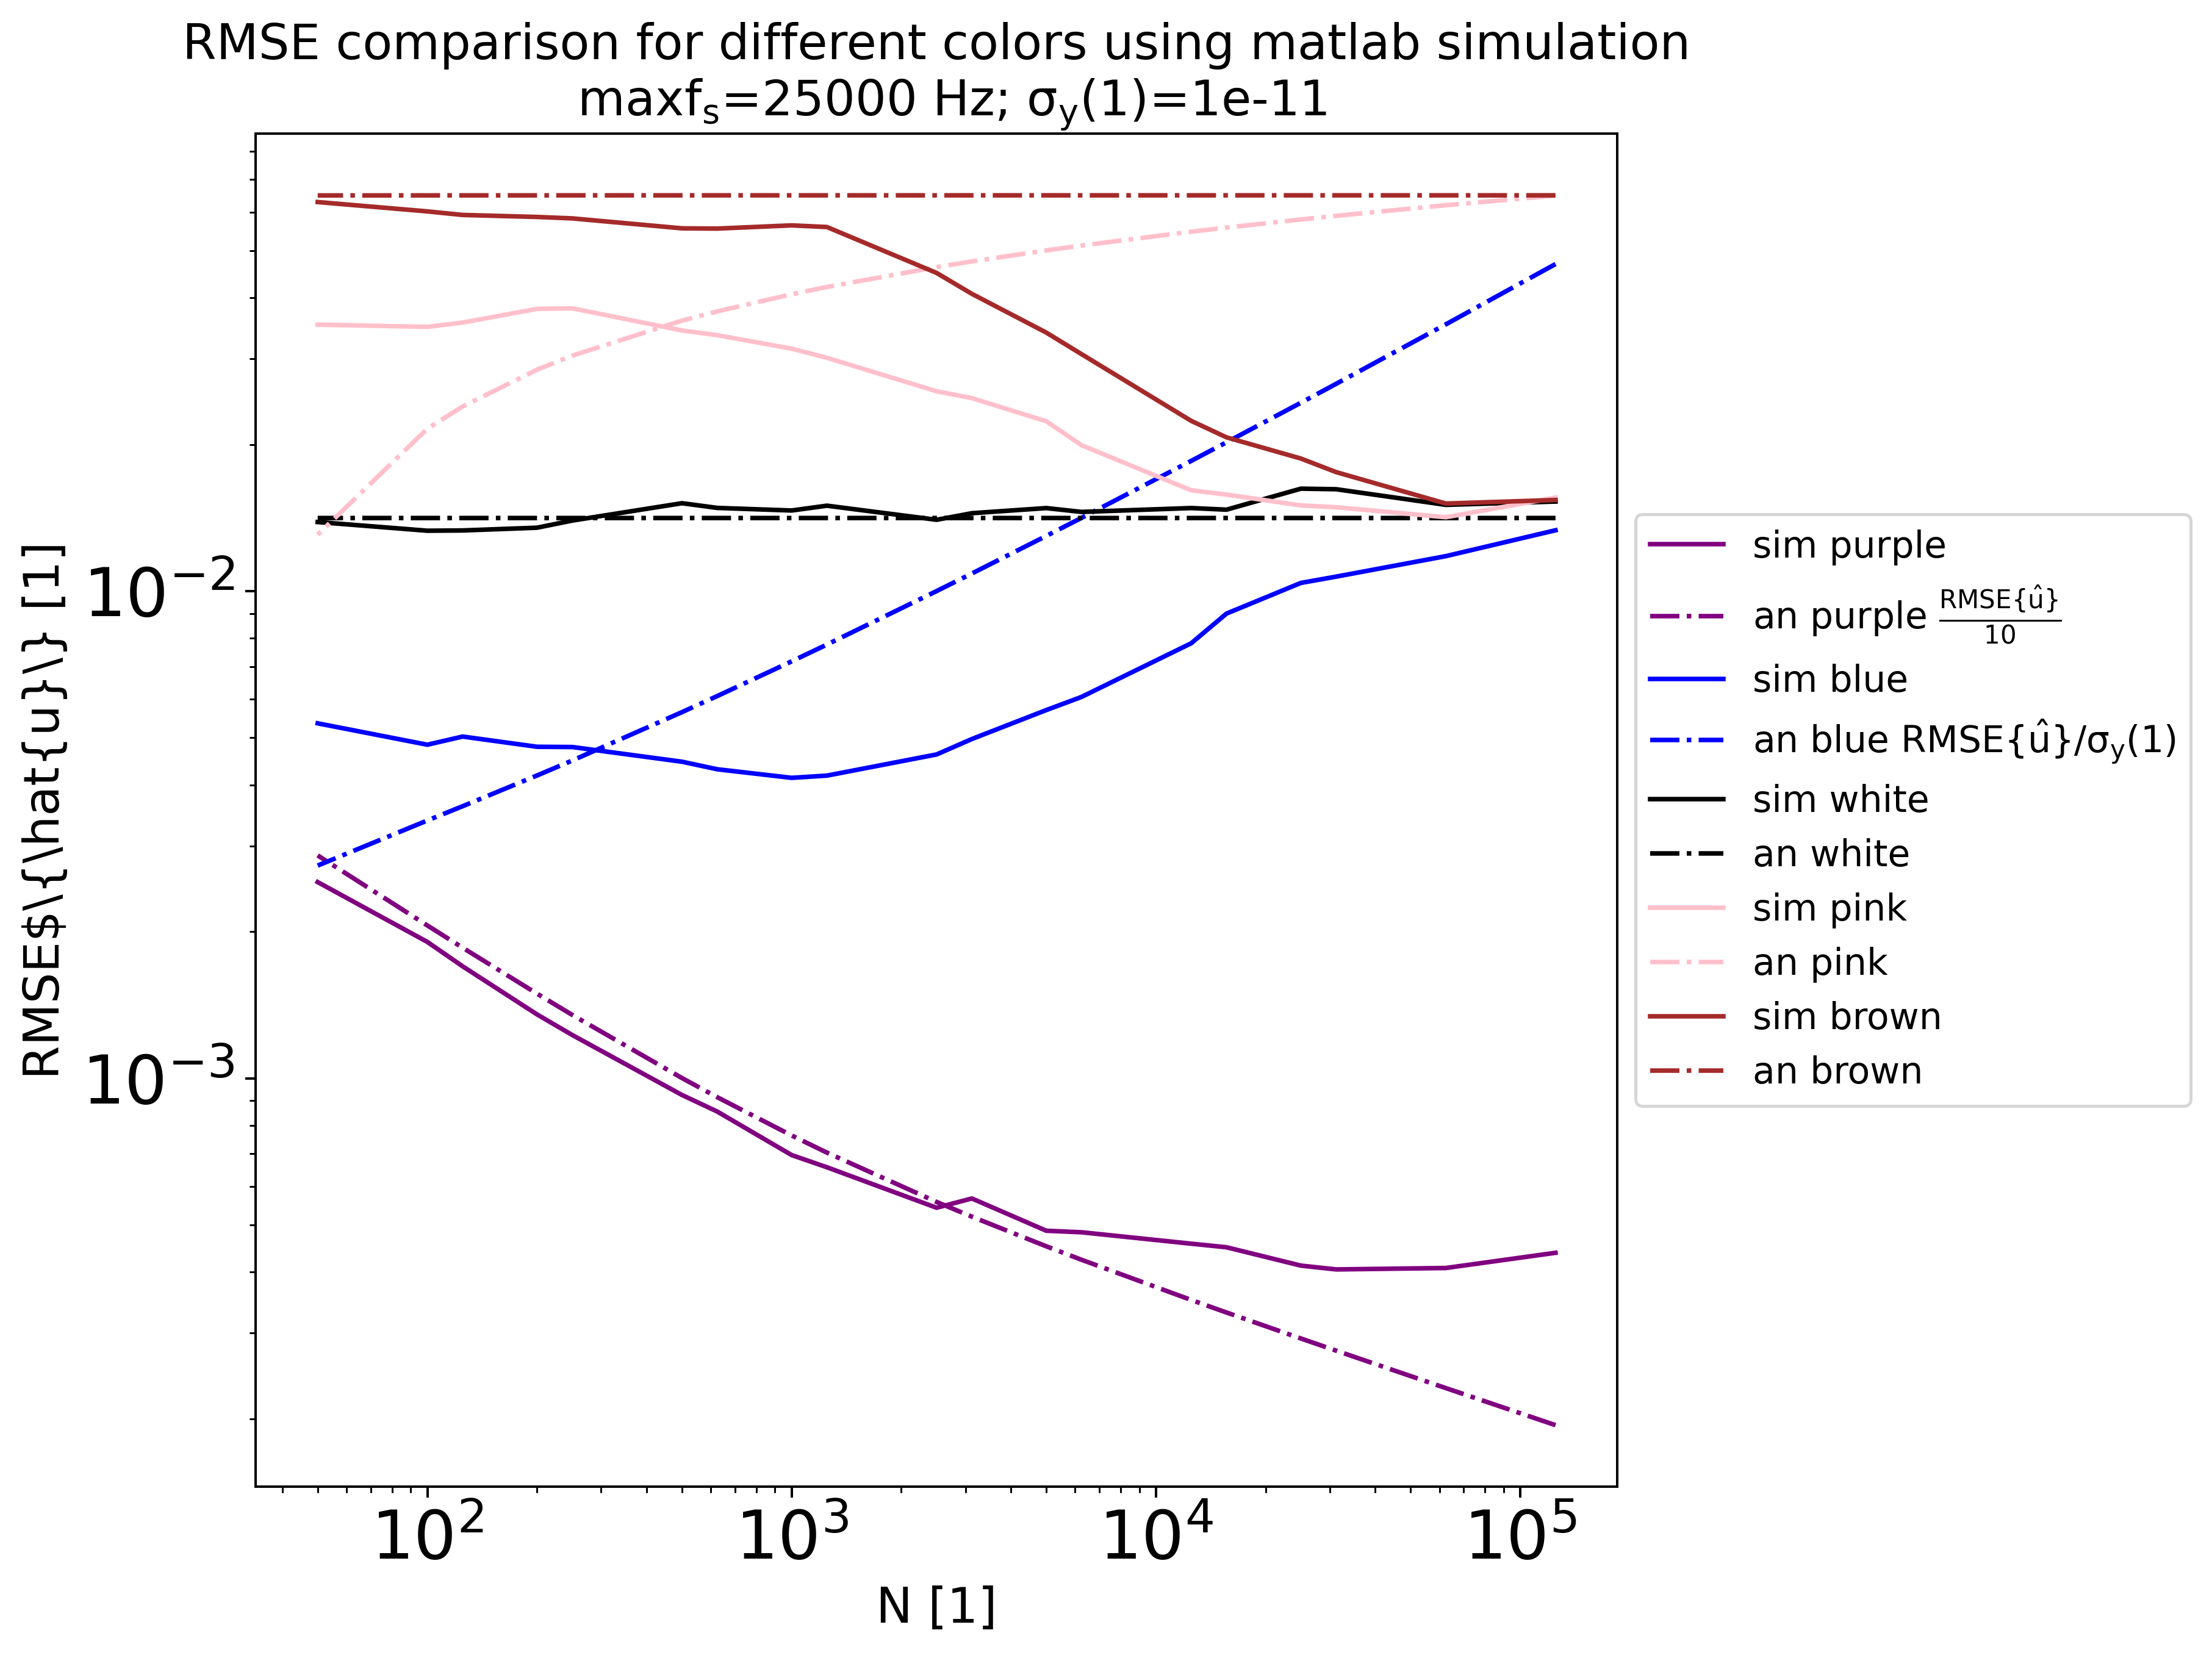

In [15]:
save_fig = True
sm_fig, sm_ax = plt.subplots(1, 1, figsize=(8, 8), dpi=360)
for color in colors:
    lcc = color
    if color == 'white':
        lcc = 'black'
    sm_ax.loglog(comparison_dict[color]['analytic']['samples_number'], comparison_dict[color]['simulation']['naive_vec_rmse'], label=f'sim {color}', color=lcc)
    if color == 'purple':
        sm_ax.loglog(comparison_dict[color]['analytic']['samples_number'], np.sqrt(comparison_dict[color]['analytic']['vec_rmse'])/10, '-.',  label=f'an {color} ' + r'$\frac{\mathrm{RMSE}\{\hat{u}\}}{10}$', color=lcc)
    elif color == 'blue':
        sm_ax.loglog(comparison_dict[color]['analytic']['samples_number'], comparison_dict[color]['analytic']['vec_rmse']/SIGNAL_PARAMS['adev'], '-.',  label=f'an {color} ' + r'RMSE$\{\hat{u}\}/\sigma_{y}(1)$', color=lcc)
    else:
        sm_ax.loglog(comparison_dict[color]['analytic']['samples_number'], comparison_dict[color]['analytic']['vec_rmse'], '-.',  label=f'an {color}', color=lcc)
sm_ax.set_xlabel('N [1]', fontsize=16)
sm_ax.set_ylabel(r'RMSE$\{\hat{u}\} [1]', fontsize=16)
sm_ax.set_title(f'RMSE comparison for different colors using matlab simulation\n'
                     + r'  $\max{f_{s}}$=' + f'{SIGNAL_PARAMS["fs"]} Hz; ' + r'$\sigma_{y}(1)$=' + f'{SIGNAL_PARAMS["adev"]}', fontsize=16)
if save_fig:
    sm_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    sm_fig.autolayout = True
    sm_fig.savefig(f'c:\\Users\\sigmu\\LyxDir\\thesis\\figures\\figures_from_jupyter\\vec_rmse_for_colored_noise.jpeg', bbox_inches='tight')
else:
    sm_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, facecolor='gray')
    sm_fig.autolayout = True
    sm_fig.patch.set_facecolor('gray')
    sm_ax.set_facecolor('gray')

In [46]:
np.polyfit(np.log10(comparison_dict['purple']['analytic']['vec_rmse'][4:-4]),
                  np.log10(comparison_dict['purple']['simulation']['vec_rmse'][4:-4]), 1)

array([ 0.44444727, -1.33984418])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


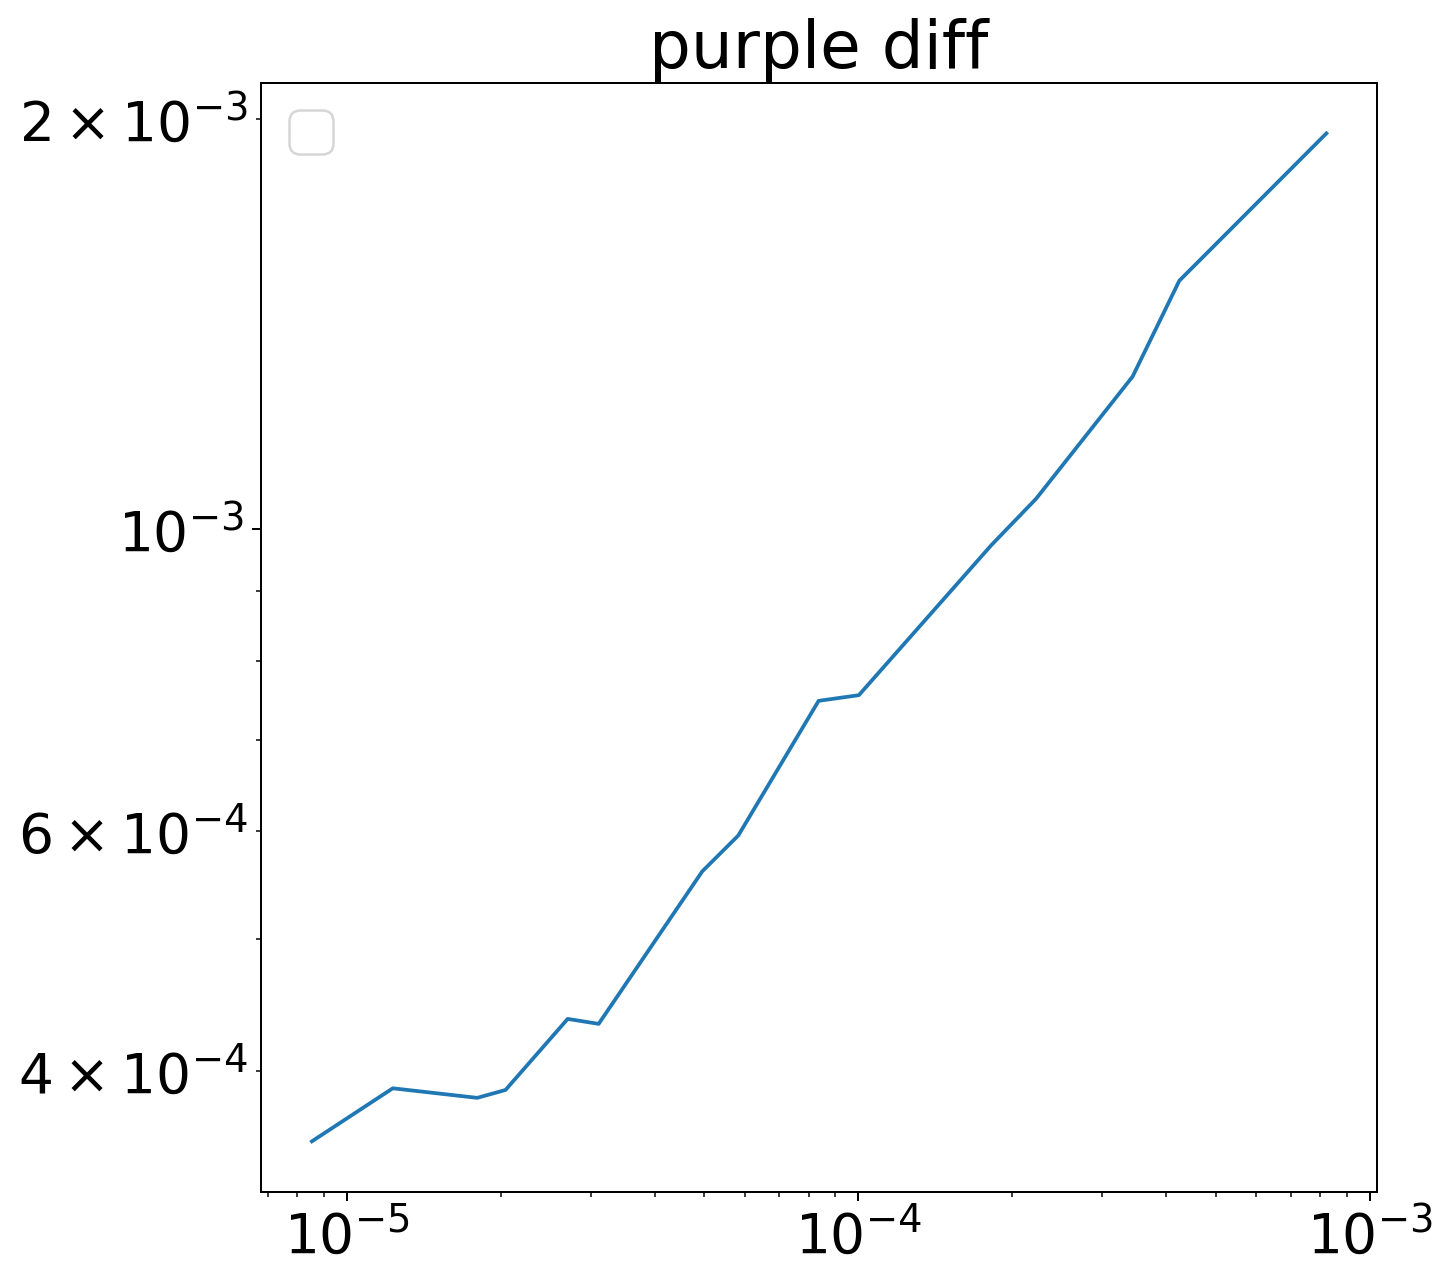

In [38]:
purple_fig, purple_ax = plt.subplots(1, 1, figsize=(8, 8), dpi=180)
purple_ax.loglog(comparison_dict['purple']['analytic']['vec_rmse'],
                  comparison_dict['purple']['simulation']['vec_rmse'])
purple_ax.set_title('purple diff')
purple_ax.legend()

In [45]:
comparison_dict['purple']['analytic']['vec_rmse'].shape

(15,)

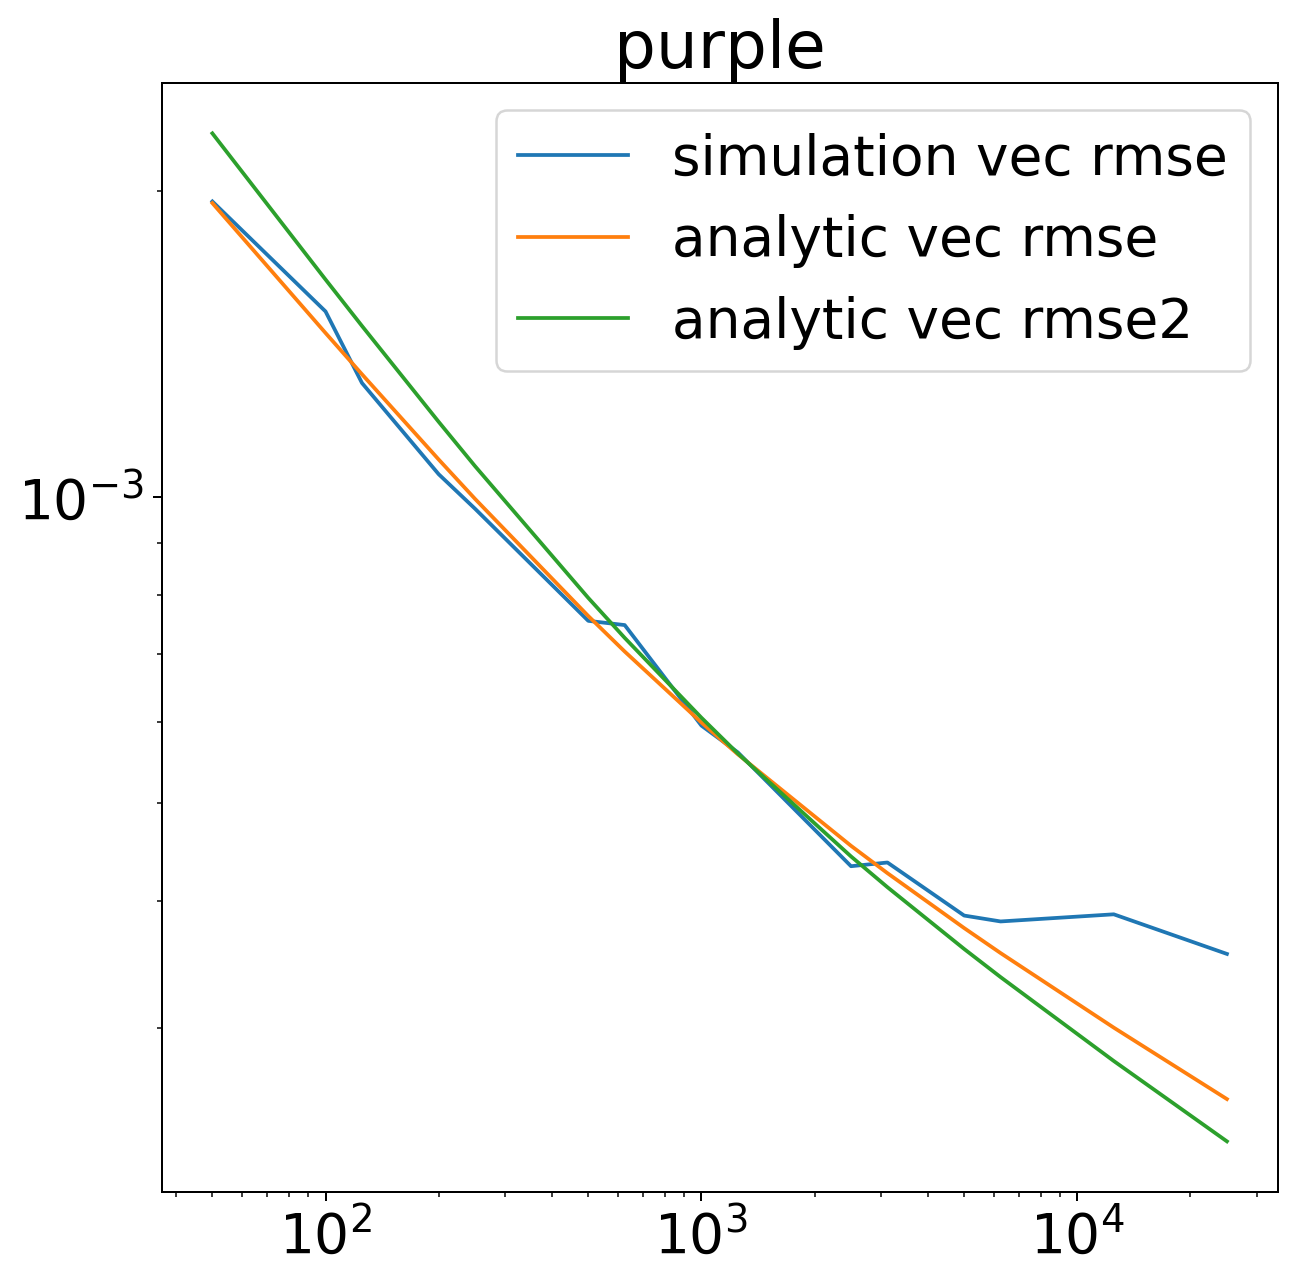

In [60]:
purple_fig, purple_ax = plt.subplots(1, 1, figsize=(8, 8), dpi=180)
purple_ax.loglog(comparison_dict['purple']['analytic']['samples_number'], comparison_dict['purple']['simulation']['vec_rmse'], label='simulation vec rmse')
purple_ax.loglog(comparison_dict['purple']['analytic']['samples_number'], (10 ** -1.34) * (comparison_dict['purple']['analytic']['vec_rmse'])**0.44444 , label='analytic vec rmse')
purple_ax.loglog(comparison_dict['purple']['analytic']['samples_number'], (10 ** -1.1) * (comparison_dict['purple']['analytic']['vec_rmse'])**0.5 , label='analytic vec rmse2')
purple_ax.set_title('purple')
purple_ax.legend()

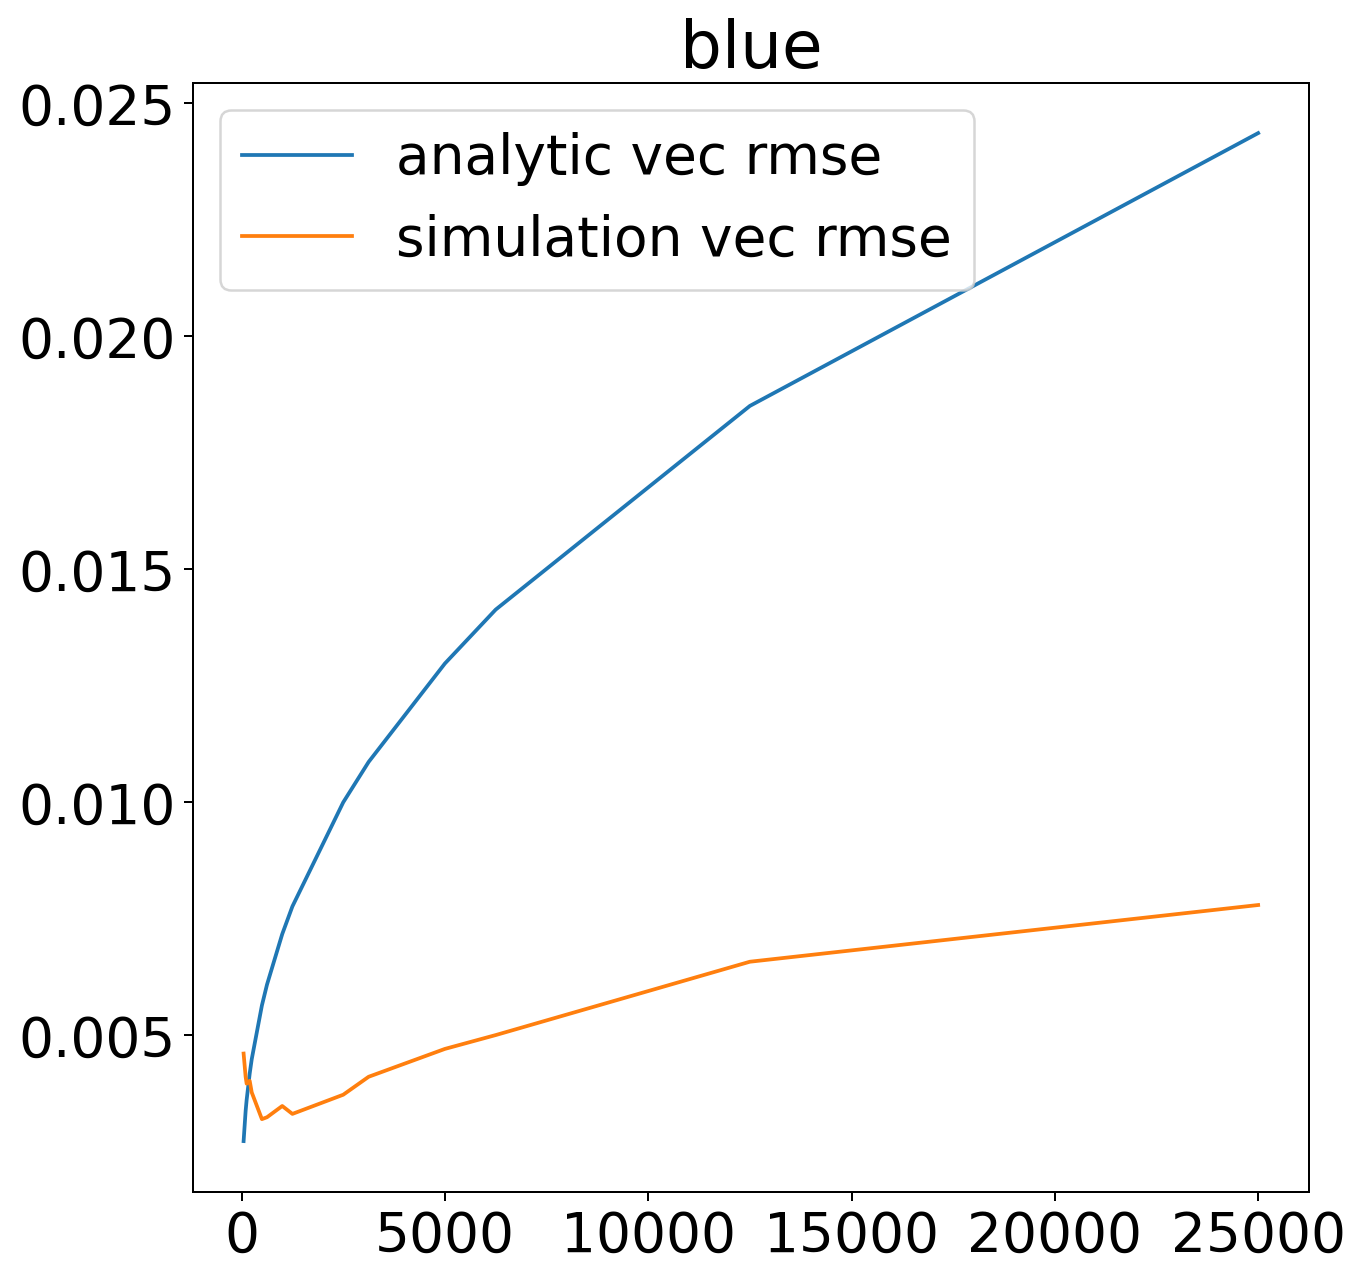

In [25]:
blue_fig, blue_ax = plt.subplots(1, 1, figsize=(8, 8), dpi=180)
blue_ax.plot(comparison_dict['blue']['analytic']['samples_number'], comparison_dict['blue']['analytic']['vec_rmse']/SIGNAL_PARAMS['adev'], label='analytic vec rmse')
blue_ax.plot(comparison_dict['blue']['analytic']['samples_number'], comparison_dict['blue']['simulation']['vec_rmse'], label='simulation vec rmse')
blue_ax.set_title('blue')
blue_ax.legend()

In [117]:
adev=SIGNAL_PARAMS['adev']
tabulu = np.zeros((5, 4))
mabulu = np.zeros((5, 4, 3, 3))
fss = [1000, 500, 200, 50]
for i, color in enumerate(COLORS_BETA.keys()):
    print('\n\n******')
    print(color)
    for j, fs in enumerate(fss):
        print(fs)
        nsig = get_colored_noise_python(color, fs, adev, ensemble_size)
        lane = create_accurate_rhumb_lane(n_samples=int(LANE_PARAMS['n_samples']/(SIGNAL_PARAMS['fs']/fs)), fs=fs)
        ns_obj = np.matmul(inv_vt_v_vt(lane['vel']), nsig)
        ns_mat = 3e+8 * np.matmul(ns_obj, ns_obj.T)/ns_obj.shape[1]
        print(ns_mat)
        mabulu[i, j, :, :] = ns_mat.copy()
        tabulu[i, j] = np.diag(ns_mat).sum()
        print(tabulu[i, j])




******
purple
1000
[[ 1.39012006e-16  4.08797948e-18 -2.83550661e-16]
 [ 4.08797948e-18  4.87649946e-17 -1.12332412e-17]
 [-2.83550661e-16 -1.12332412e-17  1.07916607e-15]]
1.2669430692510676e-15
500
[[ 2.49177951e-16  9.30610260e-18 -3.56272041e-16]
 [ 9.30610260e-18  8.76040147e-17 -2.26910304e-17]
 [-3.56272041e-16 -2.26910304e-17  1.24472289e-15]]
1.58150485622058e-15
200
[[ 3.64055918e-16  2.13904762e-18 -2.75490885e-16]
 [ 2.13904762e-18  2.15653952e-16 -2.13789505e-17]
 [-2.75490885e-16 -2.13789505e-17  1.26763667e-15]]
1.8473465432587037e-15
50
[[ 1.55761978e-15 -6.41646768e-17 -3.32473784e-16]
 [-6.41646768e-17  9.47569068e-16  5.19309121e-17]
 [-3.32473784e-16  5.19309121e-17  1.93558016e-15]]
4.44076900793536e-15


******
blue
1000
[[ 3.33318576e-14  2.64191245e-16 -5.92376396e-16]
 [ 2.64191245e-16  3.03299462e-15  8.41595454e-18]
 [-5.92376396e-16  8.41595454e-18  3.89080820e-15]]
4.025566040981456e-14
500
[[ 3.27541471e-14  1.80874943e-16 -3.14672433e-16]
 [ 1.80874943e

In [120]:
print(tabulu)
print(tabulu[:,1:]/tabulu[:,:-1])

[[1.26694307e-15 1.58150486e-15 1.84734654e-15 4.44076901e-15]
 [4.02556604e-14 4.05305335e-14 3.96613619e-14 4.14998337e-14]
 [7.59626959e-14 3.95743684e-14 1.41154555e-14 3.64148244e-15]
 [5.37623627e-14 1.77470377e-14 3.52643206e-15 2.95450058e-16]
 [5.88533693e-14 1.58564123e-14 2.70397318e-15 1.66577772e-16]]
[[1.24828407 1.16809413 2.40386354]
 [1.00682818 0.97855514 1.04635423]
 [0.52097109 0.35668176 0.25797839]
 [0.33010152 0.19870539 0.08378158]
 [0.26942234 0.17052869 0.06160482]]


Check for no noise what error it gives

In [5]:
if ensemble_size == 500 and SIGNAL_PARAMS['fs'] == 1000:
    err_by_color_and_core = np.load('plots/all_simulations_for_500.npy', allow_pickle=True)
else:
    err_by_color_and_core = {sim_core: {color: {expl: vi for expl, vi in zip(expls, get_monte_carlo_err_as_function_of_fs(vel, color, ensemble_size, sim_core))} for color in colors} for sim_core in sim_cores}

/ |#                                                  | 0 Elapsed Time: 0:00:00

generating purple noise from size (3, 5000) using matlab core


/home/sigmu/anaconda3/envs/thesis38/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 1, using nperseg = 1
  warnings.warn('nperseg = {0:d} is greater than input length '


TypeError: expected non-empty vector for x

In [ ]:
sim_fig, sim_axes = plt.subplots(3,2,figsize=(12, 10), dpi=180)
for j, (core, core_items) in enumerate(err_by_color_and_core.items()):
    for color, color_items in core_items.items():
        i = 0
        for disc, disc_val in color_items.items():
            if disc == 'samples_number':
                continue
            sim_axes[i, j].plot(color_items['samples_number'], disc_val, label=color)
            if color == 'white':
                sim_axes[i, j].set_xlabel('samples number')
                sim_axes[i, j].set_ylabel('error')
                sim_axes[i,j].set_title(f'{core}: {disc}')
            i += 1

sim_fig.tight_layout()
sim_fig.show()

In [ ]:
err_by_color_for_analytic = {color: {expl: vi for expl, vi in zip(analytic_expls, get_analytic_err_as_function_of_fs(vel, color))} for color in colors}
sim_fig, sim_axes = plt.subplots(3,3,figsize=(20, 16), dpi=360)
for j, (core, core_items) in enumerate(err_by_color_and_core.items()):
    for color, color_items in core_items.items():
        i = 0
        for disc, disc_val in color_items.items():
            if disc == 'samples_number':
                continue
            sim_axes[i, j].plot(color_items['samples_number'], disc_val, label=color)
            if color == 'white':
                sim_axes[i, j].set_xlabel('samples number')
                sim_axes[i, j].set_ylabel('error')
                sim_axes[i,j].set_title(f'{core}: {disc}')
            i += 1
j = 2
for color, color_items in err_by_color_for_analytic.items():
    lis = [2, 0, 1]
    discs = ['vec_rmse', 'angle_mae', 'angle_mae']
    for disc, i  in zip(discs, lis):
        disc_val = color_items[disc]
        sim_axes[i, j].plot(color_items['samples_number'], disc_val, label=color)
        if color == 'white' and i != 1:
            sim_axes[i, j].set_xlabel('samples number')
            sim_axes[i, j].set_ylabel('error')
            sim_axes[i, j].set_title(f'analytic: {disc}')
sim_axes[1, 2].legend()
#sim_fig.tight_layout()
#sim_fig.show()
axax = sim_axes[1, 2]
axax.grid(False)
for l in axax.lines:
    l.remove()

sim_fig.tight_layout()
sim_fig.show()